In [43]:
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LatitudeFormatter, LongitudeFormatter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
from xesmf import Regridder
from nzmeltwater.util import cleanocn
from scipy.stats import linregress

mpl.rcParams["figure.figsize"] = 6, 4
mpl.rcParams["font.size"] = 12

In [2]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    account="uoo03538", cores=8, processes=8, memory="100GB", walltime="04:00:00"
)
cluster.scale(8)

from dask.distributed import Client

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://192.168.94.167:42780,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


Task exception was never retrieved
future: <Task finished name='Task-6356125' coro=<Client._gather.<locals>.wait() done, defined at /scale_wlg_persistent/filesets/project/uoo03538/andrew.pauling/condaenvs/nzmeltwater/lib/python3.12/site-packages/distributed/client.py:2385> exception=AllExit()>
Traceback (most recent call last):
  File "/scale_wlg_persistent/filesets/project/uoo03538/andrew.pauling/condaenvs/nzmeltwater/lib/python3.12/site-packages/distributed/client.py", line 2394, in wait
    raise AllExit()
distributed.client.AllExit


### Load data to compare SST trends for HadGEM3-GC3.1-LL and ERA5

In [3]:
droot = Path("../data/processed")

odir = droot.joinpath("era5")
mdir = droot.joinpath("HadGEM3-GC31-LL")

In [26]:
ddict = {}

# Load ERA5 data
nco = list(odir.glob("*sstk*.nc"))[0]

dso = xr.open_dataset(nco, chunks={"time": -1, "latitude": -1, "longitude": -1})
dao = dso["SSTK"].sel(time=slice("1992-01", "2020-12"))

# Load CMIP6 historical data
nch = sorted(list(mdir.joinpath("historical", "Omon", "tos").glob("*historical_r*.nc")))
ncs = sorted(list(mdir.joinpath("ssp245", "Omon", "tos").glob("*ssp245_r*201501-*.nc")))

dsh = xr.open_mfdataset(nch, combine="nested", concat_dim="ensmem", chunks={"time": -1, "j": -1, "i": -1})
dss = xr.open_mfdataset(ncs, combine="nested", concat_dim="ensmem", chunks={"time": -1, "j": -1, "i": -1})

dsc = xr.concat((dsh, dss), dim="time")
ensh = [f.name.split("_")[4] for f in nch]
dsc = dsc.assign_coords({"ensmem": ("ensmem", ensh)})
dac = dsc["tos"].sel(time=slice("1992-01", "2020-12"))

# Load SOFIA experiment data
nce = sorted(
    list(mdir.joinpath("hist-antwater-92-11", "Omon", "tos").glob("*92-11_r*.nc"))
)
ense = [f.name.split("_")[4] for f in nce]

dse = cleanocn(xr.open_mfdataset(nce, combine="nested", concat_dim="ensmem"))
dse = dse.assign_coords({"ensmem": ("ensmem", ense)})
dae = dse["tos"].sel(time=slice("1992-01", "2020-12"), j=slice(1, -1), i=slice(1, -1))
dae = dae.chunk({"time": -1, "j": -1, "i": -1})

dac = dac.sel(ensmem=dae.ensmem)

ddict = {
    "era5": dao.groupby("time.year").mean("time").chunk({"year": -1}),
    "cmip6": dac.groupby("time.year").mean("time").chunk({"year": -1}),
    "sofia": dae.groupby("time.year").mean("time").chunk({"year": -1}),
}

### Compute trends and assess statistical significance

In [28]:
def new_linregress(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])


def xregress(x, y):
    ss = xr.apply_ufunc(
        new_linregress,
        x,
        y,
        input_core_dims=[["year"], ["year"]],
        output_core_dims=[["parameter"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=["float64"],
        dask_gufunc_kwargs={"output_sizes": {"parameter": 5}},
    )

    slope = ss.isel(parameter=0) * 10
    pval = ss.isel(parameter=3)

    return slope, pval

In [60]:
trenddict = {}
pvaldict = {}

for exp in ddict.keys():
    print(exp)
    if exp in ["cmip6", "sofia"]:
        data = ddict[exp].mean("ensmem")
    else:
        data = ddict[exp]
    
    trend, pval = xregress(data.year, data)

    trenddict[exp] = trend.compute()
    pvaldict[exp] = pval.compute()

In [47]:
difftrend, diffpval = xregress(ddict["cmip6"].year, (ddict["sofia"]-ddict["cmip6"]).mean("ensmem"))
difftrend = difftrend.compute()
diffpval = diffpval.compute()

### Make plots

In [59]:
def plotnz(axs, data, pval, title):
    if title in ["ERA5", "historical"]:
        data = data.rename({"latitude": "lat", "longitude": "lon"})
    axs.coastlines(zorder=101)
    axs.set_extent([145, 200, -60, -20], crs=ccrs.PlateCarree())
    axs.add_feature(cfeature.LAND, color="tab:gray", zorder=100)
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, zorder=102)
    gl.xlocator = mticker.FixedLocator([160, 180])
    gl.ylocator = mticker.FixedLocator([-45, -30, -15])
    gl.top_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.xformatter = LongitudeFormatter(dateline_direction_label=True)
    gl.xlabel_style = {"size": 8, "color": "k"}
    gl.ylabel_style = {"size": 8, "color": "k", "rotation": 90}
    
    im1 = data.plot.pcolormesh("lon", "lat", ax=axs, transform=ccrs.PlateCarree(), add_colorbar=False)
    im1.set_clim(-0.5, 0.5)
    
    levels = [0, 0.05, 0.1, 1]
    cs = pval.plot.contourf(
        "lon",
        "lat",
        ax=axs,
        transform=ccrs.PlateCarree(),
        levels=levels,
        hatches=["....", "", ""],
        colors="none",
        add_colorbar=False,
    )

    axs.set_title(title)
    
    return im1

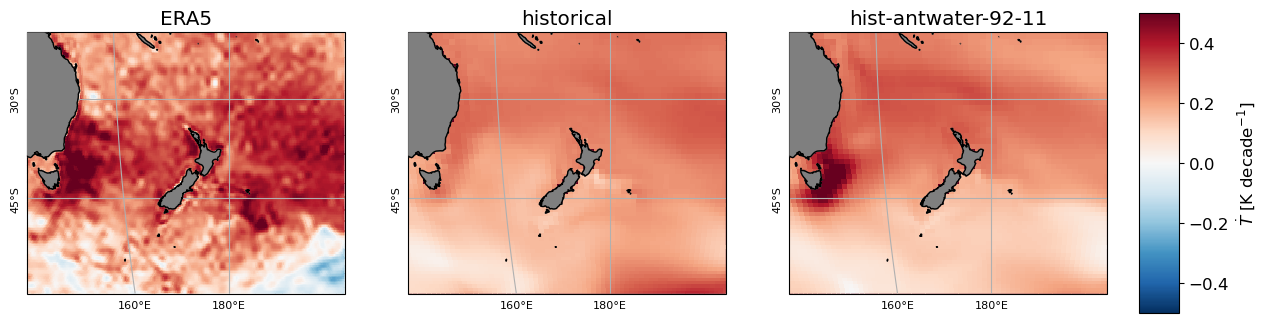

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), subplot_kw={"projection": ccrs.Robinson(central_longitude=180)})

im1 = plotnz(ax1, trenddict["era5"], "ERA5")
im2 = plotnz(ax2, trenddict["cmip6"].mean("ensmem"), "historical")
im3 = plotnz(ax3, trenddict["sofia"].mean("ensmem"), "hist-antwater-92-11")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.025, 0.75])
cb = plt.colorbar(im1, cax=cbar_ax)
cb.set_label(r"$\dot{T}$ [K decade$^{-1}$]")

fig.savefig("../figures/sst_trend_hist_comparison.png", bbox_inches="tight", dpi=300)

### Regrid p-values to a regular grid for better plotting

In [50]:
def rectilinear_regrid(da):
    # Regrid p values to rectilinear grid so that contourf works
    rlat = np.arange(-90, 91)
    rlon = np.arange(-180, 181)

    dsout = xr.DataArray(
        np.zeros((rlat.size, rlon.size)),
        dims=["j", "i"],
        coords={"lat": ("j", rlat), "lon": ("i", rlon)},
    )

    regridder = Regridder(da, dsout, method="bilinear")
    da_r = regridder(da)

    return da_r

In [51]:
ptest = rectilinear_regrid(diffpval)

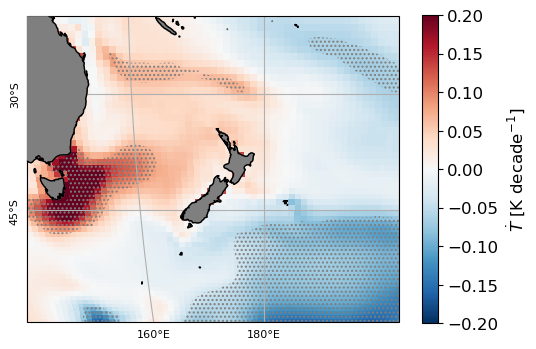

In [58]:
fig = plt.figure(1)
axs = plt.axes(projection=ccrs.Robinson(central_longitude=180))
im = plotnz(axs, difftrend, "Anomaly")
im.set_clim(-0.2, 0.2)
cb = plt.colorbar(im)
cb.set_label(r"$\dot{T}$ [K decade$^{-1}$]")

levels = [0, 0.05, 0.1, 1]
cs = ptest.plot.contourf(
    "lon",
    "lat",
    ax=axs,
    transform=ccrs.PlateCarree(),
    levels=levels,
    hatches=["....", "", ""],
    colors="none",
    add_colorbar=False,
)

cs.set_edgecolor("tab:gray")
cs.set_linewidth(0.0)

fig.savefig("../figures/sst_anomaly_trend.png", bbox_inches="tight", dpi=300)

### Compute best correlated ensemble member for each and plot (not used)

In [9]:
regridder = xe.Regridder(
    trenddict["era5"],
    trenddict["cmip6"],
    method="bilinear",
    periodic=False,
)

trenddict["era5_regrid"] = regridder(trenddict["era5"])

In [10]:
def mean2(x):
    y = np.sum(x) / np.size(x)
    return y


def corr2(a, b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a * b).sum() / np.sqrt((a * a).sum() * (b * b).sum())
    return r

In [11]:
ensh = [f.name.split("_")[4] for f in nch]
enss = [f.name.split("_")[4] for f in nce]

trenddict["cmip6"] = trenddict["cmip6"].assign_coords({"ensmem": ("ensmem", ensh)})
trenddict["sofia"] = trenddict["sofia"].assign_coords({"ensmem": ("ensmem", enss)})

In [12]:
bestcorrdict = {}
bestpvaldict = {}

for exp in ["cmip6", "sofia"]:
    for n, ens in enumerate(trenddict["sofia"].ensmem.data):
        corrout = xr.DataArray(
            np.zeros(10),
            dims=["ensmem"],
            coords={"ensmem": ("ensmem", trenddict["sofia"].ensmem.data)},
        )
        corrout[n] = corr2(trenddict[exp].sel(ensmem=ens), trenddict["era5_regrid"])

    maxind = int(corrout.argmax().data)

    bestcorrdict[exp] = trenddict[exp].isel(ensmem=maxind)
    bestpvaldict[exp] = pvaldict[exp].isel(ensmem=maxind)

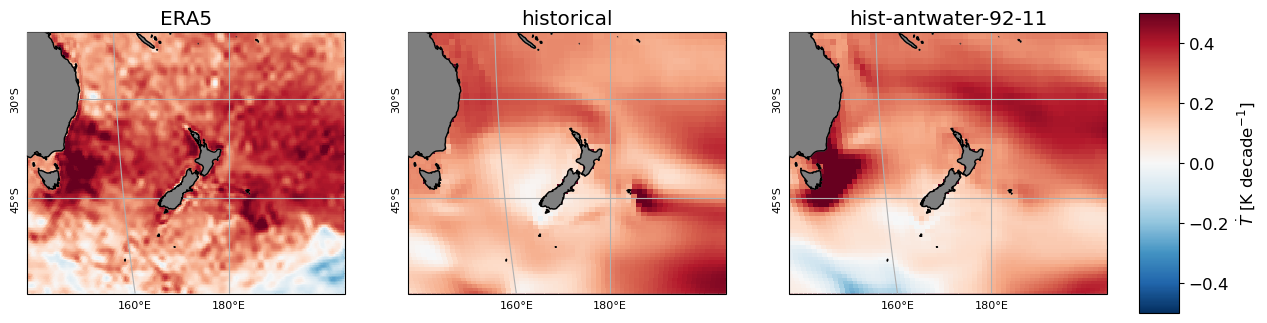

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), subplot_kw={"projection": ccrs.Robinson(central_longitude=180)})

im1 = plotnz(ax1, trenddict["era5"], "ERA5")
im2 = plotnz(ax2, bestcorrdict["cmip6"], "historical")
im3 = plotnz(ax3, bestcorrdict["sofia"], "hist-antwater-92-11")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.025, 0.75])
cb = plt.colorbar(im1, cax=cbar_ax)
cb.set_label(r"$\dot{T}$ [K decade$^{-1}$]")

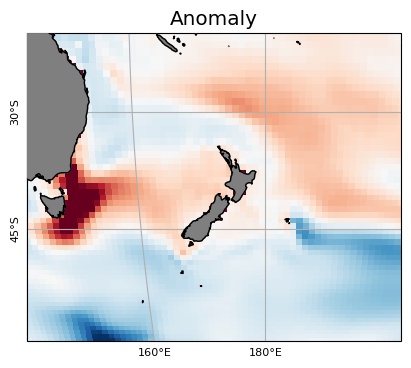

In [15]:
fig = plt.figure(1)
axs = plt.axes(projection=ccrs.Robinson(central_longitude=180))
im = plotnz(axs, bestcorrdict["sofia"] - bestcorrdict["cmip6"], "Anomaly")